# Interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import os
import pickle
import random

plt.rcParams['font.size'] = 18
plt.rc('font', size=18)
plt.rc('legend', fontsize=14)

In [2]:
# def get_dist(results_root_path):
#     try:
#         fingertip_target_distance_last_step = np.load(results_root_path + \
#                                                     "/fingertip_target_distance_last_step.npy")
#         print("fingertip_target_distance_last_step", fingertip_target_distance_last_step.shape)
#     except FileNotFoundError:
#         return 0, 0, 0, np.array([0])
    
#     fingertip_target_distance_last_step *= 100
#     # fingertip_target_distance_last_step = fingertip_target_distance_last_step.reshape(5, 5, -1)
#     mean_dist_arr = np.mean(fingertip_target_distance_last_step, axis=-1)
    
#     print("mean_dist_arr", mean_dist_arr.shape)
#     print("-")
#     return mean_dist_arr #, fingertip_target_distance_last_step

def get_fingertip_target_traj(results_root_path):
    file_path = os.path.join(results_root_path, 'fingertip_traj_trains.pkl')
    with open(file_path, 'rb') as f:
        fingertip_target_traj_trains = pickle.load(f)
    fingertip_target_traj_trains = np.array(fingertip_target_traj_trains)
    fingertip_target_traj_trains *= 100
    return fingertip_target_traj_trains

def get_distance_in_each_step(fingertip_target_traj_trains):
    end_effector_coords = fingertip_target_traj_trains[:, :, :, :, :2]
    target_coords = fingertip_target_traj_trains[:, :, :, :, 2:]

    distances_steps = np.linalg.norm(end_effector_coords - target_coords, axis=-1)
    return distances_steps

def get_dist(results_root_path):
    fingertip_target_traj_trains = get_fingertip_target_traj(results_root_path)
    print("fingertip_target_traj_trains", fingertip_target_traj_trains.shape)
    distances_steps = get_distance_in_each_step(fingertip_target_traj_trains)
    distances_last_step = distances_steps[:, :, :, -1]
    print("distances_last_step", distances_last_step.shape) #(train, test, episode, step)
    distances_last_st_episodes = np.mean(distances_last_step, axis=-1) 
    # distances_episodes = distances_episodes.reshape(5, 5, -1)
    last_step_dist_arr = np.mean(distances_last_st_episodes, axis=-1)
    print("last_step_dist_arr", last_step_dist_arr.shape)
    print("-")
    return last_step_dist_arr

In [3]:
def get_torques_loss(results_root_path):
    try:
        torq_err_model_trains = np.load(results_root_path + \
                                                    "/torq_err_model_trains.npy")
        print("torq_err_model_trains", torq_err_model_trains.shape)
    except FileNotFoundError:
        raise FileNotFoundError
    try:
        torq_err_base_trains = np.load(results_root_path + \
                                                    "/torq_err_base_trains.npy")
        print("Offline:")
        print("dnfc", np.mean(torq_err_model_trains), np.std(torq_err_model_trains))
        print("mlp", np.mean(torq_err_base_trains), np.std(torq_err_model_trains))
    except:
        pass
    
    # torq_err_model_trains = torq_err_model_trains.reshape(5, 5, -1)
    torq_err_model_arr = np.mean(torq_err_model_trains, axis=-1)
    print("torq_err_model_arr", torq_err_model_arr.shape)
    print("-")
    return torq_err_model_arr

In [4]:
def get_tracking_error(results_root_path):
    fingertip_target_traj_trains = get_fingertip_target_traj(results_root_path)
    print("fingertip_target_traj_trains", fingertip_target_traj_trains.shape)
    distances_steps = get_distance_in_each_step(fingertip_target_traj_trains)
    print("distances_steps", distances_steps.shape)
    distances_episodes = np.mean(distances_steps, axis=-1) #(train, test, episode, step)
    # distances_episodes = distances_episodes.reshape(5, 5, -1)
    tracking_err_arr = np.mean(distances_episodes, axis=-1)
    print("tracking_err_arr", tracking_err_arr.shape)
    print("-")
    return tracking_err_arr
        

In [5]:
def get_results_model(metrics, results_root_path):
    print("results_root_path", results_root_path)
    dist_arr = get_dist(results_root_path)
    metrics['dist_mod_arr'].append(dist_arr)

    torq_err_model_arr = get_torques_loss(results_root_path)
    metrics['torq_err_mod_arr'].append(torq_err_model_arr)

    track_err_mod_arr = get_tracking_error(results_root_path)
    metrics['track_err_mod_arr'].append(track_err_mod_arr)

    print("---")
    return metrics

In [6]:
metrics_model = {
    'dist_mod_arr': [],
    'torq_err_mod_arr': [],
    'track_err_mod_arr': [],
}

metrics_base = {
    'dist_mod_arr': [],
    'torq_err_mod_arr': [],
    'track_err_mod_arr': [],
}

metrics_cont = {
    'dist_mod_arr': [],
    'torq_err_mod_arr': [],
    'track_err_mod_arr': [],
}


# num_params_model = {"0.27": 1200, "0.57": 1200, "1.846": 1200} #"0.57":480,
# num_params_base = {"0.269": 1200, "0.575": 1200, "1.806": 1200} #"0.575":480,
num_params_model = {"1.846": 40}
num_params_base = {"1.806": 40}
episodes_nums = 2000
C_const = 2
D = 3
E = 1
model_params_list = list(num_params_model.keys())
base_params_list = list(num_params_base.keys())
for i in range(len(model_params_list)):
    n_p_m = model_params_list[i]
    results_root_path = "./test_results/dynamic_train/dynamic_targets/cartesian/online/random_test_set"
    results_root_path += f"/{episodes_nums}_man_tra|cus_los_{C_const}_{D}_{E}|st_vel_norm"
    results_root_path += f"|tar_cart|{n_p_m}K_params|epoch_{num_params_model[n_p_m]}"# + "_0"
    metrics_model = get_results_model(metrics_model, results_root_path)

    n_p_m = model_params_list[i]
    if n_p_m == "1.846":
        results_root_path_cont = "./test_results/dynamic_train/dynamic_targets/cartesian/offline/random_test_set"
        results_root_path_cont += f"/{episodes_nums}_man_tra|cus_los_{C_const}_{D}_{E}|st_vel_norm"
        results_root_path_cont += f"|tar_cart|{n_p_m}K_params|epoch_2000" + "_0"
        metrics_cont = get_results_model(metrics_cont, results_root_path_cont)

    n_p_b = base_params_list[i]
    results_root_path_base = "./test_results/dynamic_train/dynamic_targets/cartesian/online/random_test_set"
    results_root_path_base += f"/{episodes_nums}_man_tra|mse_los|st_vel_norm"
    results_root_path_base += f"|tar_cart|base|{n_p_b}K_params|epoch_{num_params_base[n_p_b]}"# + "_0"
    metrics_base = get_results_model(metrics_base, results_root_path_base)   
    
    print("=====")

results_root_path ./test_results/dynamic_train/dynamic_targets/cartesian/online/random_test_set/2000_man_tra|cus_los_2_3_1|st_vel_norm|tar_cart|1.846K_params|epoch_40
fingertip_target_traj_trains (3, 1, 500, 200, 4)
distances_last_step (3, 1, 500)
last_step_dist_arr (3,)
-
torq_err_model_trains (3, 1, 500)
torq_err_model_arr (3, 1)
-
fingertip_target_traj_trains (3, 1, 500, 200, 4)
distances_steps (3, 1, 500, 200)
tracking_err_arr (3, 1)
-
---
results_root_path ./test_results/dynamic_train/dynamic_targets/cartesian/offline/random_test_set/2000_man_tra|cus_los_2_3_1|st_vel_norm|tar_cart|1.846K_params|epoch_2000_0
fingertip_target_traj_trains (3, 1, 500, 200, 4)
distances_last_step (3, 1, 500)
last_step_dist_arr (3,)
-
torq_err_model_trains (3, 1, 500)
Offline:
dnfc 0.00200977106089614 0.001016115459318037
mlp 0.0017396056862699983 0.001016115459318037
torq_err_model_arr (3, 1)
-
fingertip_target_traj_trains (3, 1, 500, 200, 4)
distances_steps (3, 1, 500, 200)
tracking_err_arr (3, 1)
-
-

In [7]:
print(metrics_model)
print("---")
print(metrics_base)
print("---")
print(metrics_cont)

{'dist_mod_arr': [array([0.67538954, 0.5287727 , 0.81755485])], 'torq_err_mod_arr': [array([[0.04276362],
       [0.04524588],
       [0.05222204]])], 'track_err_mod_arr': [array([[0.96771334],
       [0.97131091],
       [1.06420704]])]}
---
{'dist_mod_arr': [array([3.31251512, 3.8734776 , 1.12701556])], 'torq_err_mod_arr': [array([[0.15939294],
       [0.18315368],
       [0.08240032]])], 'track_err_mod_arr': [array([[3.56592   ],
       [4.00588211],
       [1.58518034]])]}
---
{'dist_mod_arr': [array([0.04221343, 0.04221343, 0.04221343])], 'torq_err_mod_arr': [array([[0.00186253],
       [0.00219136],
       [0.00197542]])], 'track_err_mod_arr': [array([[0.60065352],
       [0.60065352],
       [0.60065352]])]}


In [8]:
stats_model = {
    'size': 0,
    'dist_mean': [],
    'dist_std': [],
    'torq_err_mean': [],
    'torq_err_std': [],
    'track_err_mean': [],
    'track_err_std': []
}

stats_base = {
    'size': 0,
    'dist_mean': [],
    'dist_std': [],
    'torq_err_mean': [],
    'torq_err_std': [],
    'track_err_mean': [],
    'track_err_std': []
}

stats_cont = {
    'size': 0,
    'dist_mean': [],
    'dist_std': [],
    'torq_err_mean': [],
    'torq_err_std': [],
    'track_err_mean': [],
    'track_err_std': []
}


def fill_stats(metrics, stats):
    for dist_arr in metrics['dist_mod_arr']:
        stats['dist_mean'].append(np.mean(dist_arr))
        stats['dist_std'].append(np.std(dist_arr))

    for torq_err_arr in metrics['torq_err_mod_arr']:
        stats['torq_err_mean'].append(np.mean(torq_err_arr))
        stats['torq_err_std'].append(np.std(torq_err_arr))

    for track_err_arr in metrics['track_err_mod_arr']:
        stats['track_err_mean'].append(np.mean(track_err_arr))
        stats['track_err_std'].append(np.std(track_err_arr))
        stats['size'] = np.size(track_err_arr)

    return stats

stats_model = fill_stats(metrics_model, stats_model)
stats_base = fill_stats(metrics_base, stats_base)
stats_cont = fill_stats(metrics_cont, stats_cont)

In [9]:
print(stats_model)
print("---")
print(stats_base)
print("---")
print(stats_cont)

{'size': 3, 'dist_mean': [0.6739056965487943], 'dist_std': [0.11789948451412768], 'torq_err_mean': [0.0467438469489723], 'torq_err_std': [0.004004026887573302], 'track_err_mean': [1.0010770955900428], 'track_err_std': [0.04466376588977051]}
---
{'size': 3, 'dist_mean': [2.77100276064526], 'dist_std': [1.1848178925696782], 'torq_err_mean': [0.14164897969404922], 'torq_err_std': [0.04300345795928659], 'track_err_mean': [3.0523274837298655], 'track_err_std': [1.0528634670882662]}
---
{'size': 3, 'dist_mean': [0.04221343055267676], 'dist_std': [0.0], 'torq_err_mean': [0.0020097710608961406], 'torq_err_std': [0.00013642684441305346], 'track_err_mean': [0.600653517423006], 'track_err_std': [0.0]}


In [10]:
from scipy.stats import ttest_ind

for i in range(len(metrics_model['dist_mod_arr'])):
    dist_arr = metrics_model['dist_mod_arr'][i].reshape(-1)
    dist_arr_base = metrics_base['dist_mod_arr'][i].reshape(-1)
    print("shape", dist_arr.shape, dist_arr_base.shape)
    statistic, pvalue= ttest_ind(dist_arr, dist_arr_base, equal_var=False)
    print(statistic, pvalue)
    print("===")

shape (3,) (3,)
-2.4908198680821836 0.12797942220205472
===


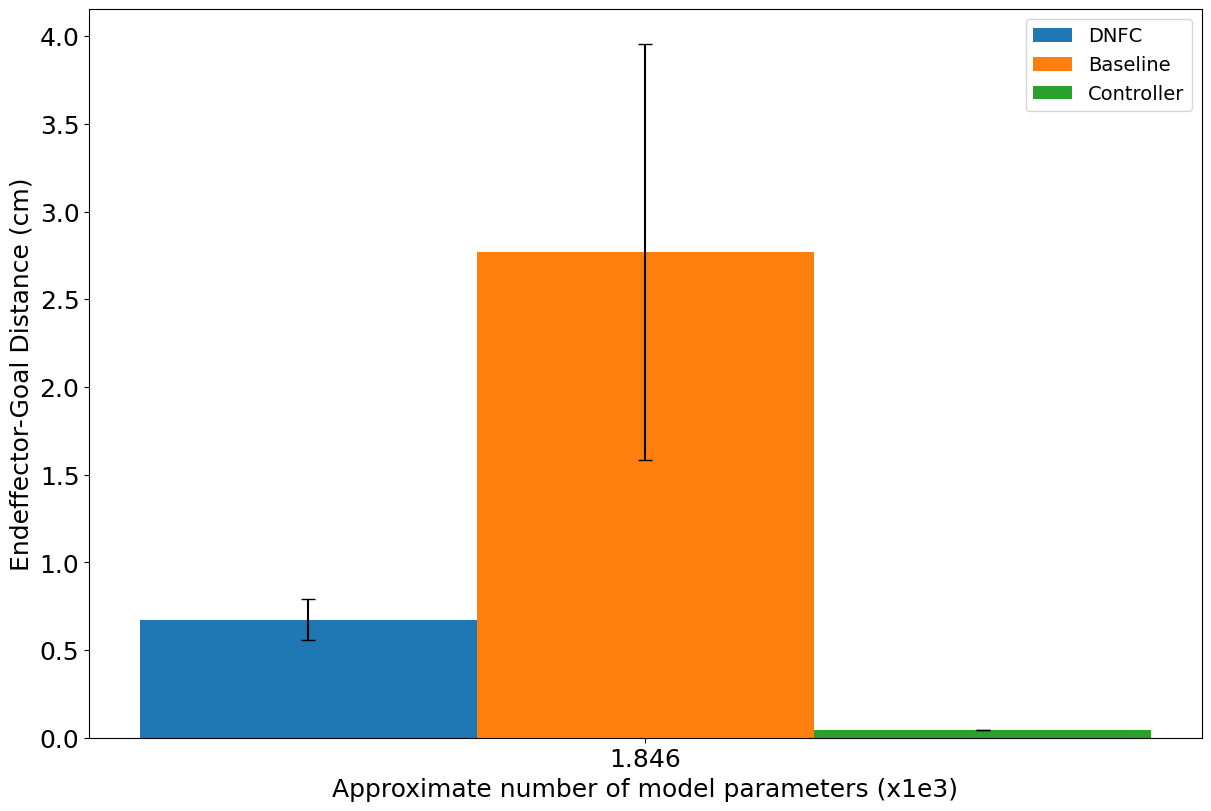

{'DNFC': [0.6739056965487943], 'Baseline': [2.77100276064526], 'Controller': [0.04221343055267676]}
{'DNFC': [0.11789948451412768], 'Baseline': [1.1848178925696782], 'Controller': [0.0]}


In [11]:
Ys = {
    'DNFC': [x for x in stats_model['dist_mean']],
    'Baseline': [x for x in stats_base['dist_mean']],
    'Controller': [x for x in stats_cont['dist_mean']],
    # 'DNFC-ablation': [x for x in stats['dist_mean_mse']],
}

errors = {
    'DNFC': [x for x in stats_model['dist_std']],
    'Baseline': [x for x in stats_base['dist_std']],
    'Controller': [x for x in stats_cont['dist_std']],
    # 'DNFC-ablation': [x for x in stats['dist_sem_mse']],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Endeffector-Goal Distance (cm)')
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), "tmp_result/dist.png"))
plt.show()

print(Ys)
print(errors)

In [12]:
# track_err_mod_arr
for i in range(len(metrics_model['track_err_mod_arr'])):
    track_err_arr = metrics_model['track_err_mod_arr'][i].reshape(-1)
    track_err_arr_base = metrics_base['track_err_mod_arr'][i].reshape(-1)
    print("shape", track_err_arr.shape, track_err_arr_base.shape)
    statistic, pvalue= ttest_ind(track_err_arr, track_err_arr_base, equal_var=False)
    print(statistic, pvalue)
    print("===")

shape (3,) (3,)
-2.7527780649920977 0.11008553995841089
===


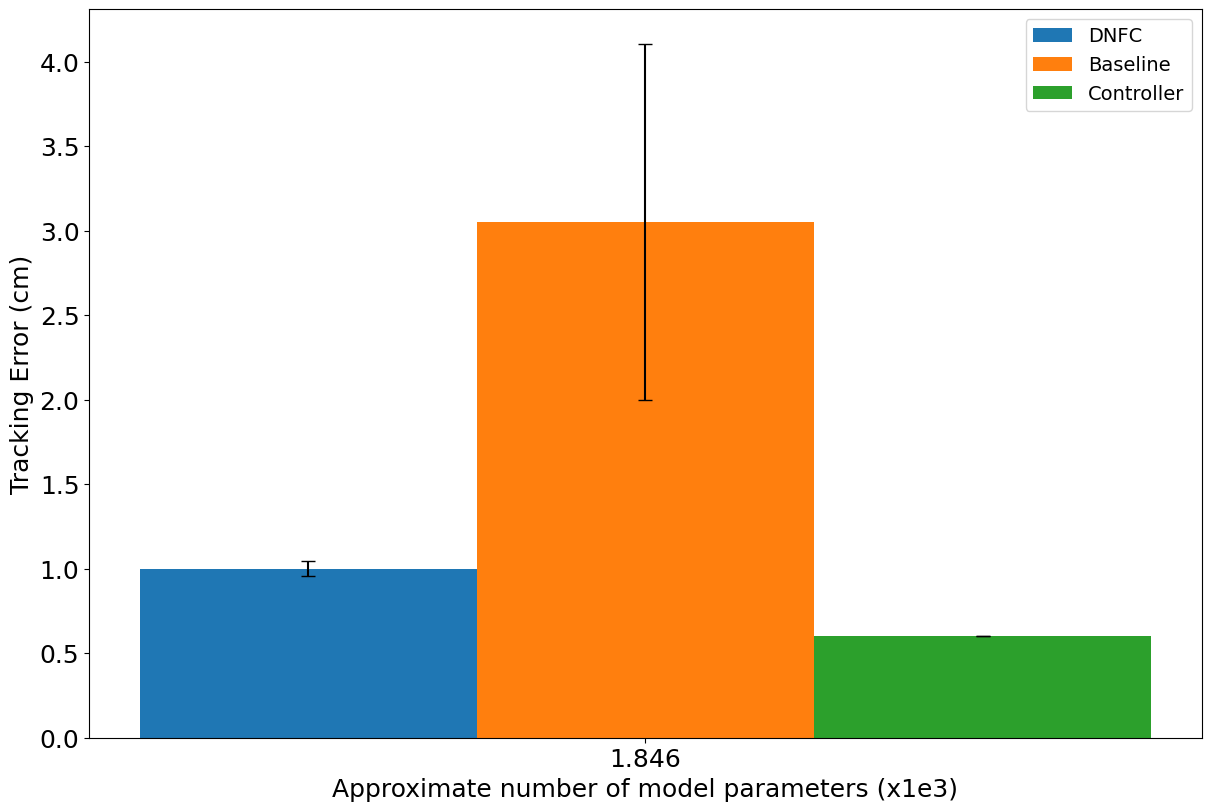

{'DNFC': [1.0010770955900428], 'Baseline': [3.0523274837298655], 'Controller': [0.600653517423006]}
{'DNFC': [0.04466376588977051], 'Baseline': [1.0528634670882662], 'Controller': [0.0]}


In [13]:
Ys = {
    'DNFC': [x for x in stats_model['track_err_mean']],
    'Baseline': [x for x in stats_base['track_err_mean']],
    'Controller': [x for x in stats_cont['track_err_mean']],
    # 'DNFC-ablation': [x for x in stats['dist_mean_mse']],
}

errors = {
    'DNFC': [x for x in stats_model['track_err_std']],
    'Baseline': [x for x in stats_base['track_err_std']],
    'Controller': [x for x in stats_cont['track_err_std']],
    # 'DNFC-ablation': [x for x in stats['dist_sem_mse']],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Tracking Error (cm)')
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), "tmp_result/track_err.png"))
plt.show()
print(Ys)
print(errors)

In [14]:
for i in range(len(metrics_model['torq_err_mod_arr'])):
    torq_loss_arr = metrics_model['torq_err_mod_arr'][i].reshape(-1)
    torq_loss_arr_base = metrics_base['torq_err_mod_arr'][i].reshape(-1)
    print("shape", torq_loss_arr.shape, torq_loss_arr_base.shape)
    statistic, pvalue = ttest_ind(torq_loss_arr, torq_loss_arr_base, equal_var=False)
    print(statistic, pvalue)
    print("===")

shape (3,) (3,)
-3.1076128216108243 0.08789430113549113
===


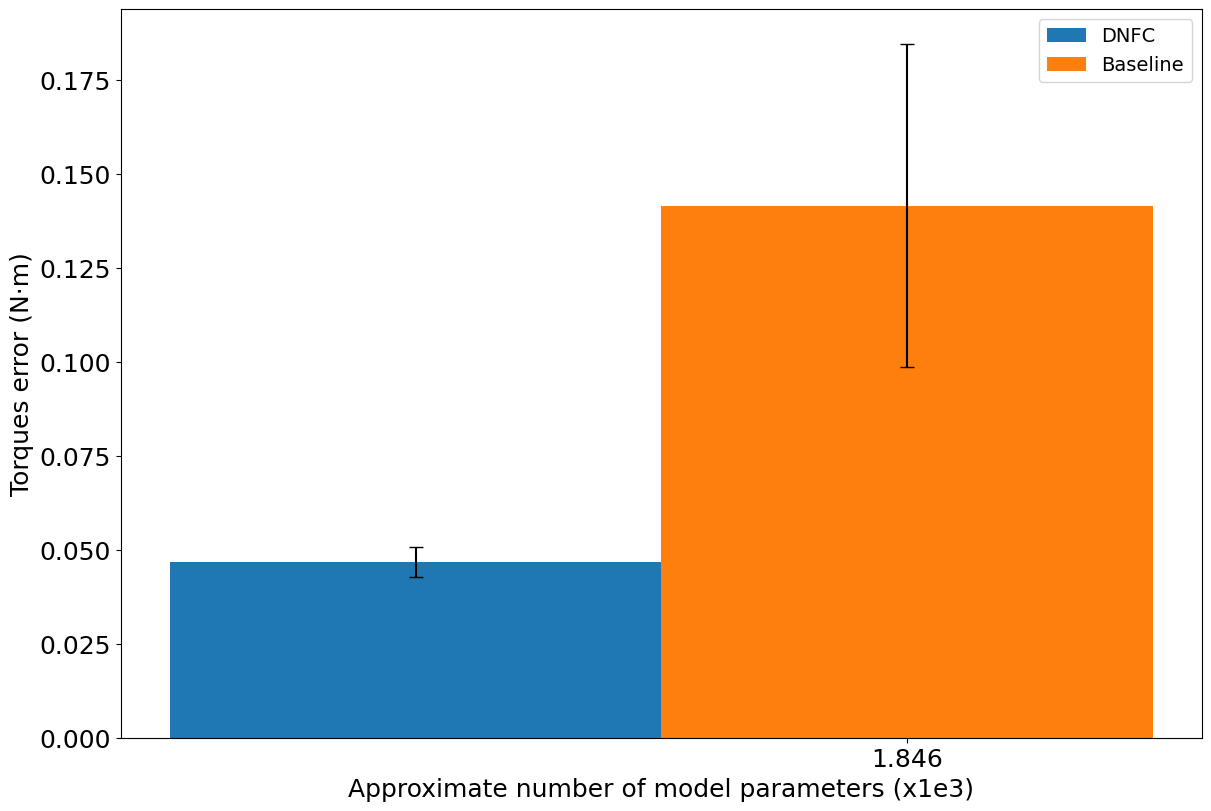

{'DNFC': [0.0467438469489723], 'Baseline': [0.14164897969404922]}
{'DNFC': [0.004004026887573302], 'Baseline': [0.04300345795928659]}


In [15]:
Ys = {
    'DNFC': [x for x in stats_model['torq_err_mean']],
    'Baseline': [x for x in stats_base['torq_err_mean']],
    # 'DNFC-ablation': [x for x in stat['torques_loss_mean_mse']],
}

errors = {
    'DNFC': [x for x in stats_model['torq_err_std']],
    'Baseline': [x for x in stats_base['torq_err_std']],
    # 'DNFC-ablation': [x for x in stats['torques_loss_sem_mse']],
}

# colors = {
#     'DNFC': 'teal',  # You can use color names or hex color codes
#     'Baseline': 'goldenrod'
# }

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})#, color=colors[attribute])
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Torques error (N⋅m)')
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Torque Prediction Error')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), "tmp_result/torq_err.png"))
plt.show()
print(Ys)
print(errors)

In [16]:
print(results_root_path)
print(results_root_path_base)
print(results_root_path_cont)

file_path = os.path.join(results_root_path, 'fingertip_traj_trains.pkl')
with open(file_path, 'rb') as f:
    fingertip_traj_trains = pickle.load(f)
fingertip_traj_trains = np.array(fingertip_traj_trains)
fingertip_traj_trains *= 100
print(fingertip_traj_trains.shape)

file_path = os.path.join(results_root_path_base, 'fingertip_traj_trains.pkl')
with open(file_path, 'rb') as f:
    fingertip_traj_trains_base = pickle.load(f)
fingertip_traj_trains_base = np.array(fingertip_traj_trains_base)
fingertip_traj_trains_base *= 100
print(fingertip_traj_trains_base.shape)

file_path = os.path.join(results_root_path_cont, 'fingertip_traj_trains.pkl')
with open(file_path, 'rb') as f:
    fingertip_traj_trains_cont = pickle.load(f)
fingertip_traj_trains_cont = np.array(fingertip_traj_trains_cont)
fingertip_traj_trains_cont *= 100
print(fingertip_traj_trains_cont.shape)

./test_results/dynamic_train/dynamic_targets/cartesian/online/random_test_set/2000_man_tra|cus_los_2_3_1|st_vel_norm|tar_cart|1.846K_params|epoch_40
./test_results/dynamic_train/dynamic_targets/cartesian/online/random_test_set/2000_man_tra|mse_los|st_vel_norm|tar_cart|base|1.806K_params|epoch_40
./test_results/dynamic_train/dynamic_targets/cartesian/offline/random_test_set/2000_man_tra|cus_los_2_3_1|st_vel_norm|tar_cart|1.846K_params|epoch_2000_0
(3, 1, 500, 200, 4)
(3, 1, 500, 200, 4)
(3, 1, 500, 200, 4)


300 2
fingertip_traj_trains (3, 1, 500, 200, 4)
300 0
fingertip_traj_trains (3, 1, 500, 200, 4)
193 0
fingertip_traj_trains (3, 1, 500, 200, 4)
193 2
fingertip_traj_trains (3, 1, 500, 200, 4)


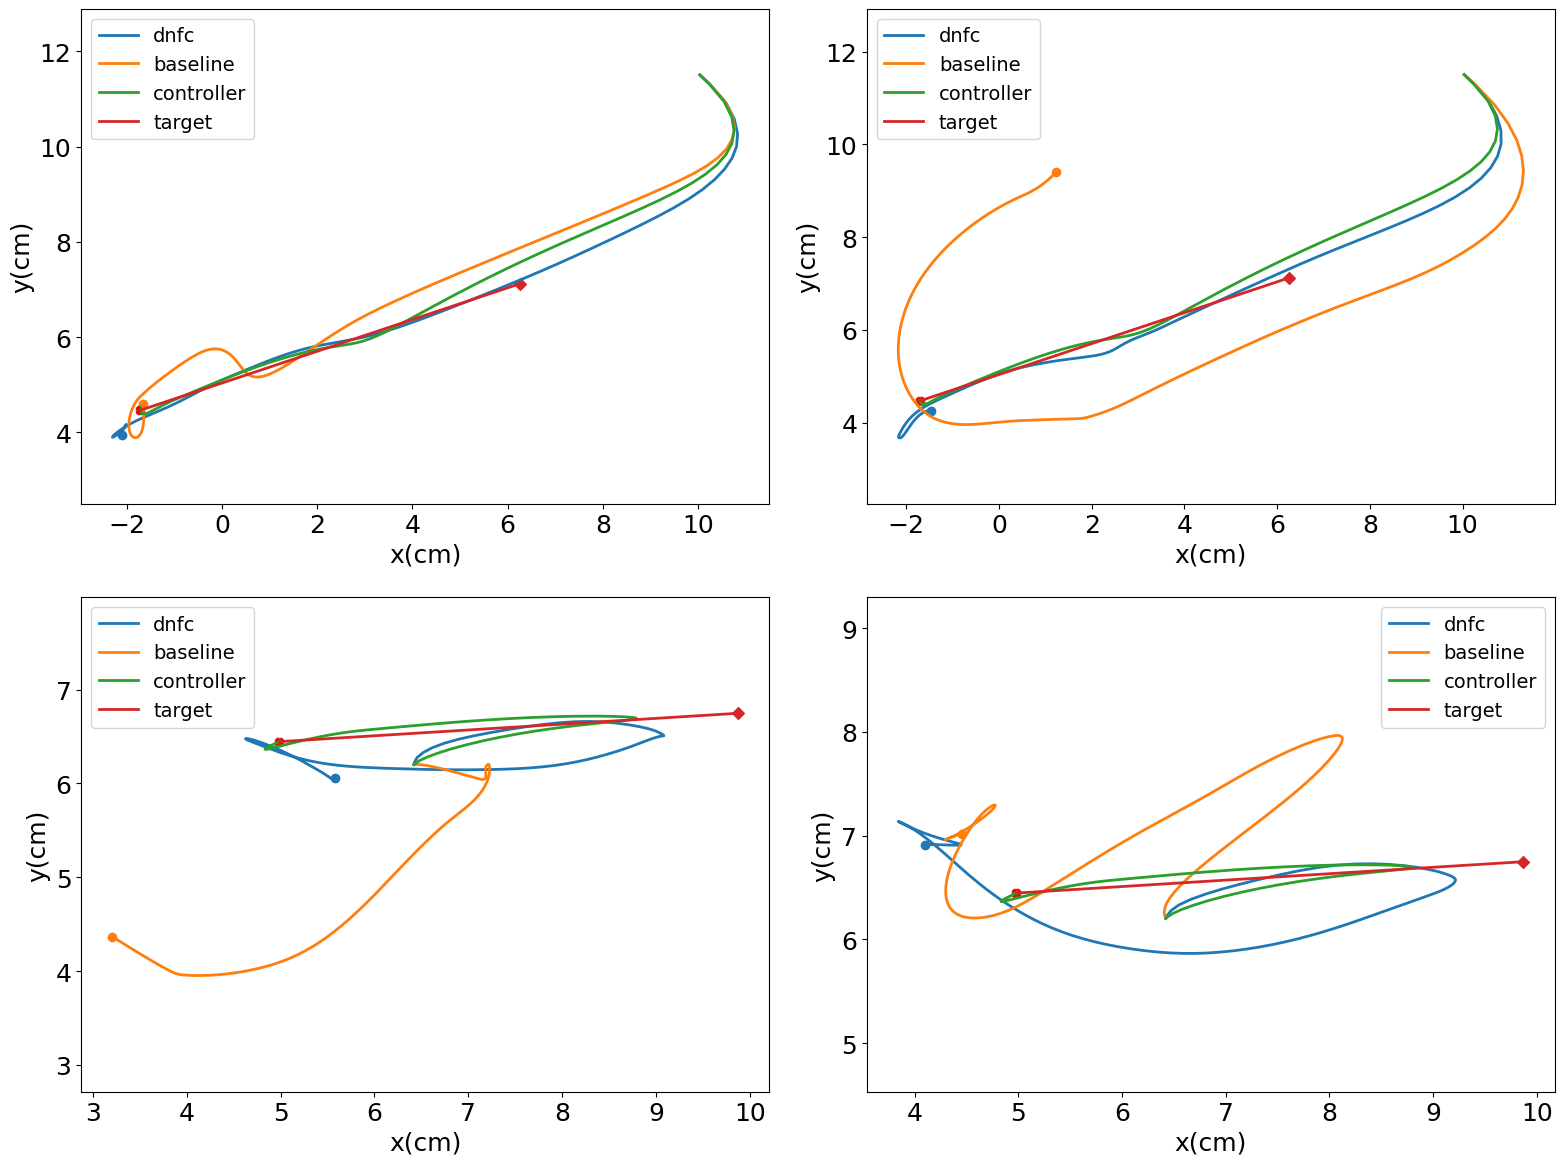

In [21]:
plt.figure(figsize=(16, 12))

i_ax = 1
for _ in range(2):
    episode_no = np.random.randint(0, 500)
    train_indices = random.sample(range(3), 2)
    for train_no in train_indices:
        plt.subplot(2, 2, i_ax)
        test_no = 0 
        print(episode_no, train_no)
        print("fingertip_traj_trains", fingertip_traj_trains.shape)
        fingertip_traj_steps = fingertip_traj_trains[train_no, test_no, episode_no, :, :]
        plt.plot(fingertip_traj_steps[:, 0], fingertip_traj_steps[:, 1], #color='green', 
                    label='dnfc', linewidth=2)
        plt.scatter(fingertip_traj_steps[-1, 0], fingertip_traj_steps[-1, 1])

        fingertip_traj_steps_base = fingertip_traj_trains_base[train_no, test_no, episode_no, :, :]
        plt.plot(fingertip_traj_steps_base[:, 0], fingertip_traj_steps_base[:, 1], 
                    label='baseline', linewidth=2)
        plt.scatter(fingertip_traj_steps_base[-1, 0], fingertip_traj_steps_base[-1, 1])

        fingertip_traj_steps_cont = fingertip_traj_trains_cont[0, test_no, episode_no, :, :]
        plt.plot(fingertip_traj_steps_cont[:, 0], fingertip_traj_steps_cont[:, 1],
                    label='controller', linewidth=2)
        plt.scatter(fingertip_traj_steps_cont[-1, 0], fingertip_traj_steps_cont[-1, 1])

        plt.plot(fingertip_traj_steps[:, 2], fingertip_traj_steps[:, 3], #color='orange', 
                    label='target', linewidth=2)
        plt.scatter(fingertip_traj_steps[0, 2], fingertip_traj_steps[0, 3], marker='D')
        plt.scatter(fingertip_traj_steps[-1, 2], fingertip_traj_steps[-1, 3], color='red', 
                    marker='X')

        plt.xlabel('x(cm)')
        plt.ylabel('y(cm)')
        plt.axis('equal')
        plt.legend()
        i_ax += 1

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "tmp_result/trajs.png"))
plt.show()